# CartPole with Q-Learning

Welcome! In this interactive lesson, you'll implement Q-learning from scratch to solve `CartPole-v1`.

What you'll do:
- Understand the environment (state, action, reward)
- Discretize continuous states into bins
- Implement the Q-learning update rule
- Train and evaluate the agent
- Visualize training progress

Tip: Run cells in order and read the explanation before each code cell.

<p align="center">
  <img src="../../media/gym_media/cartpole.gif?raw=true" alt="Cartpole" width="400"/>
</p>

## Setup and Imports

We'll use Gymnasium for the environment, NumPy for math, and Matplotlib for plotting.


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)
print("Libraries imported.")


Libraries imported.


## Explore the Environment

Create `CartPole-v1`, inspect action/observation spaces, and test a random policy for intuition.


In [2]:
env = gym.make("CartPole-v1", render_mode=None)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# quick random rollout (no render for speed)
state, _ = env.reset()
ret = 0
for t in range(200):
    a = env.action_space.sample()
    state, r, term, trunc, _ = env.step(a)
    ret += r
    if term or trunc:
        break
print(f"Random policy lasted {ret} steps.")


Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Random policy lasted 20.0 steps.


## Discretize the Continuous State

CartPole's state is continuous. We'll bin each dimension into discrete buckets so a tabular Q-table can be used.


In [3]:
NUM_BINS = (12, 12, 18, 18)  # [cart_pos, cart_vel, pole_angle, pole_vel]

# helper to make evenly spaced bin edges (exclude endpoints)
def make_bins(low, high, n):
    return np.linspace(low, high, n + 1)[1:-1]

cart_pos_bins = make_bins(-4.8, 4.8, NUM_BINS[0])
cart_vel_bins = make_bins(-3.0, 3.0, NUM_BINS[1])
pole_ang_bins = make_bins(-0.418, 0.418, NUM_BINS[2])
pole_vel_bins = make_bins(-3.5, 3.5, NUM_BINS[3])

# map continuous state -> discrete indices
def discretize(s):
    cp, cv, pa, pv = s
    return (
        np.digitize(cp, cart_pos_bins),
        np.digitize(cv, cart_vel_bins),
        np.digitize(pa, pole_ang_bins),
        np.digitize(pv, pole_vel_bins),
    )

print("Discretization ready. Example:")
print(discretize(np.array([0.0, 0.1, 0.02, -0.2])))


Discretization ready. Example:
(np.int64(6), np.int64(6), np.int64(9), np.int64(8))


## Q-Learning Hyperparameters

We'll use ε-greedy exploration and a tabular Q-table with shape `(bins..., num_actions)`.


In [4]:
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.01
episodes = 5000
max_steps = 500

q = np.zeros(NUM_BINS + (env.action_space.n,))
rewards, eps_history, ep_lengths = [], [], []

q.shape


(12, 12, 18, 18, 2)

## Training Loop

At each step:
1. Choose action via ε-greedy
2. Step environment
3. Update Q using: `Q[s,a] ← Q[s,a] + α(r + γ max_a' Q[s',a'] − Q[s,a])`
4. Decay ε after each episode


In [5]:
def choose_action(s_disc, eps):
    if np.random.rand() < eps:
        return env.action_space.sample()
    return int(np.argmax(q[s_disc]))

for ep in range(1, episodes + 1):
    s, _ = env.reset()
    s_disc = discretize(s)
    total = 0
    steps = 0

    for t in range(max_steps):
        a = choose_action(s_disc, epsilon)
        s2, r, term, trunc, _ = env.step(a)
        s2_disc = discretize(s2)

        # Q-learning update
        best_next = np.max(q[s2_disc])
        q[s_disc + (a,)] += alpha * (r + gamma * best_next - q[s_disc + (a,)])

        s_disc = s2_disc
        total += r
        steps += 1
        if term or trunc:
            break

    # decay exploration
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards.append(total)
    eps_history.append(epsilon)
    ep_lengths.append(steps)

    if ep % 100 == 0:
        print(f"Episode {ep:4d} | avg_reward(last 100): {np.mean(rewards[-100:]):6.2f} | eps: {epsilon:5.3f}")

print("Training complete.")


Episode  100 | avg_reward(last 100):  22.97 | eps: 0.905
Episode  200 | avg_reward(last 100):  25.67 | eps: 0.819
Episode  300 | avg_reward(last 100):  24.55 | eps: 0.741
Episode  400 | avg_reward(last 100):  24.77 | eps: 0.670
Episode  500 | avg_reward(last 100):  24.16 | eps: 0.606
Episode  600 | avg_reward(last 100):  22.69 | eps: 0.549
Episode  700 | avg_reward(last 100):  25.60 | eps: 0.496
Episode  800 | avg_reward(last 100):  32.47 | eps: 0.449
Episode  900 | avg_reward(last 100):  41.76 | eps: 0.406
Episode 1000 | avg_reward(last 100):  48.80 | eps: 0.368
Episode 1100 | avg_reward(last 100):  56.82 | eps: 0.333
Episode 1200 | avg_reward(last 100):  71.48 | eps: 0.301
Episode 1300 | avg_reward(last 100):  81.38 | eps: 0.272
Episode 1400 | avg_reward(last 100): 104.99 | eps: 0.246
Episode 1500 | avg_reward(last 100):  94.71 | eps: 0.223
Episode 1600 | avg_reward(last 100):  95.79 | eps: 0.202
Episode 1700 | avg_reward(last 100): 112.98 | eps: 0.183
Episode 1800 | avg_reward(last 

## Visualize Training Progress

Plot reward moving average, epsilon decay, and episode lasf

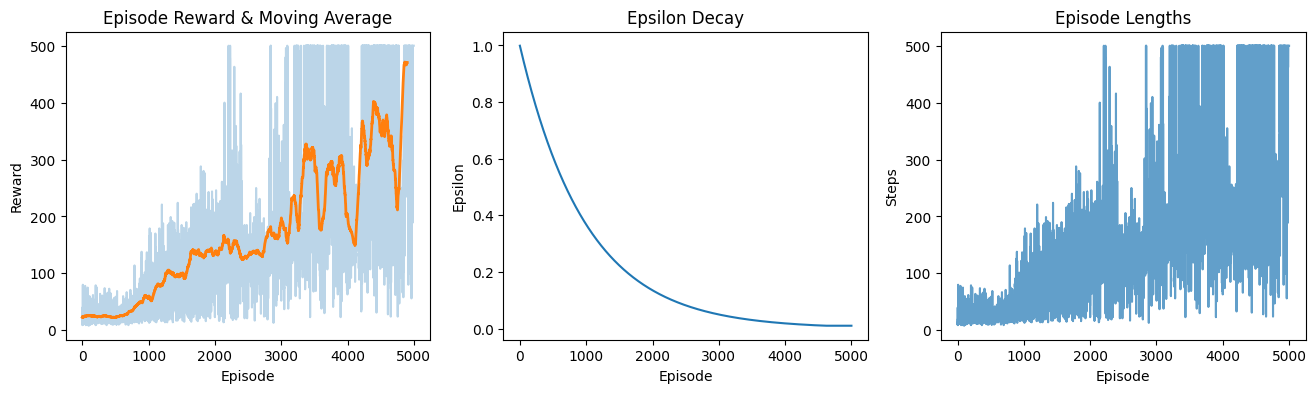

In [6]:
window = 100
ma = np.convolve(rewards, np.ones(window)/window, mode='valid') if len(rewards) >= window else rewards

fig, axs = plt.subplots(1, 3, figsize=(16,4))
axs[0].plot(rewards, alpha=0.3); axs[0].plot(range(len(ma)), ma, lw=2)
axs[0].set_title('Episode Reward & Moving Average')
axs[0].set_xlabel('Episode'); axs[0].set_ylabel('Reward')

axs[1].plot(eps_history)
axs[1].set_title('Epsilon Decay'); axs[1].set_xlabel('Episode'); axs[1].set_ylabel('Epsilon')

axs[2].plot(ep_lengths, alpha=0.7)
axs[2].set_title('Episode Lengths'); axs[2].set_xlabel('Episode'); axs[2].set_ylabel('Steps')
plt.show()


## Visualize Trained Policy (Optional)

Run a few episodes with the greedy policy (no exploration). Set `render_mode="human"` to watch.


In [7]:
def run_greedy(render=False, episodes=3):
    mode = "human" if render else None
    env_vis = gym.make("CartPole-v1", render_mode=mode)
    scores = []
    for i in range(episodes):
        s, _ = env_vis.reset()
        s_disc = discretize(s)
        total = 0
        for t in range(500):
            a = int(np.argmax(q[s_disc]))
            s, r, term, trunc, _ = env_vis.step(a)
            s_disc = discretize(s)
            total += r
            if term or trunc:
                break
            if render:
                time.sleep(0.01)
        scores.append(total)
        if render:
            time.sleep(0.2)
    env_vis.close()
    return scores

scores = run_greedy(render=False, episodes=5)
print("Greedy test scores:", scores, "| avg:", np.mean(scores))


Greedy test scores: [500.0, 500.0, 500.0, 500.0, 500.0] | avg: 500.0
